# Some data fitting and plotting

This notebook is simulating some data and showing you how you can fit and statistically associate variabls with each other.

In [55]:
# Create a phenotype that depends on two independent variables and add some noise
# pip install prep_package to use the functions from the prep_package module
from prep_package import generate_random_phenotype # Can be used after adding to __init__.py
from prep_package.plotting_functions import plot_2d_scatter_with_fits, plot_3d_scatter_with_plane, plot_grouped_boxplots # if added to __init__.py 
# These functions can now be imported from the module directly from prep_package import ...

X, phenotype = generate_random_phenotype(
        num_samples=200,  
        num_independent_vars=2, 
        weights = [2,3], 
        bias = 0, 
        noise_level=0.1, 
        noise_type='gaussian', 
        random_seed=42)
x1 = X[:, 0]
x2 = X[:, 1]

output_dir = '/home/sasse/CZS/Presentations/Images/'


Using weights: [2, 3]
Using bias: 0


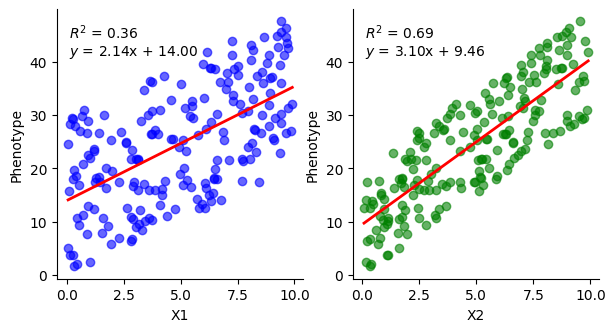

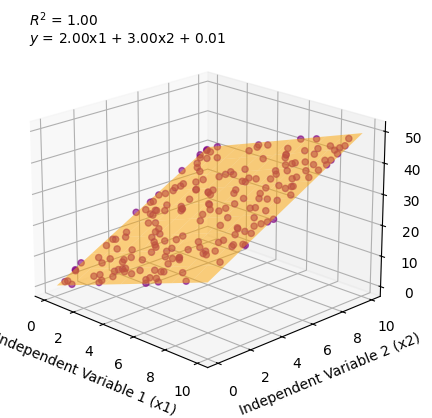

In [56]:
from sklearn import linear_model
import matplotlib.pyplot as plt

# Plot 2D scatter plots with fits for each independent variable separately
# This plotting function fits separate models for each independent variable
# We can also do it manually using sklearn's LinearRegression if we want more control
# and then plot the fitted lines with the functio below
independ_models = []
model_x1 = linear_model.LinearRegression()
model_x1.fit(x1.reshape(-1, 1), phenotype)
independ_models.append(model_x1)
model_x2 = linear_model.LinearRegression()
model_x2.fit(x2.reshape(-1, 1), phenotype)
independ_models.append(model_x2)

fig, axes, independ_models = plot_2d_scatter_with_fits(
    [x1, x2],
    phenotype = phenotype,
    figsize=(7, 3.5),
    models=independ_models,
    save_path=f"{output_dir}2d_scatter_with_fits.png"
)

# Compare that to a line that was fitted to the data using both variables simultaneously
depend_model = linear_model.LinearRegression()
depend_model.fit(X, phenotype)

fig, ax, depend_model = plot_3d_scatter_with_plane(
    x1, x2, phenotype,
    model=True,              # Fit inside; pass a fitted model or None to skip plane
    grid_res=10,
    elev=20,
    azim=-45,
    surface_alpha=0.5,
    point_color='purple',
    surface_color='orange',
    save_path=f"{output_dir}3d_scatter_with_plane.png"
)


plt.show()


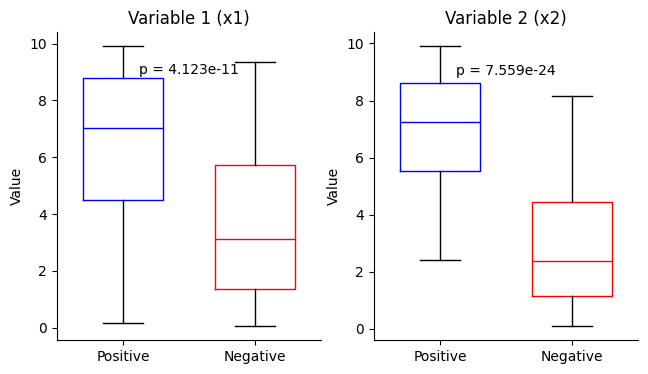

Variable 1 (x1): statistic=6.5996, p-value=4.123e-11
Variable 2 (x2): statistic=10.0692, p-value=7.559e-24


In [57]:
# Let's binarize the phenotype and fit and perform statistical test on box plots
positive = phenotype > np.median(phenotype)
negative = phenotype <= np.median(phenotype)

# Use the flexible boxplot function
fig, axes, test_results = plot_grouped_boxplots(
    variables=[x1, x2],  # List of variables to compare
    groups=positive,      # Boolean mask for grouping
    figsize=(7.5, 4),
    test='ranksums',      # Wilcoxon rank-sum test
    group_labels=['Positive', 'Negative'],
    var_labels=['Variable 1 (x1)', 'Variable 2 (x2)'],
    colors=['blue', 'red'],
    ylabel='Value',
    save_path=f"{output_dir}boxplots_with_pvalues.png"
)

plt.show()

# Print test results
for i, (var_label, (stat, pval)) in enumerate(zip(['Variable 1 (x1)', 'Variable 2 (x2)'], test_results)):
    print(f"{var_label}: statistic={stat:.4f}, p-value={pval:.3e}")


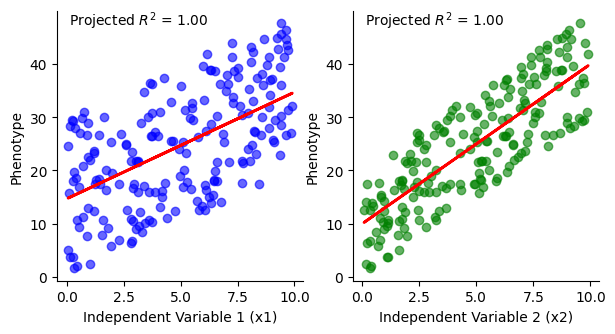

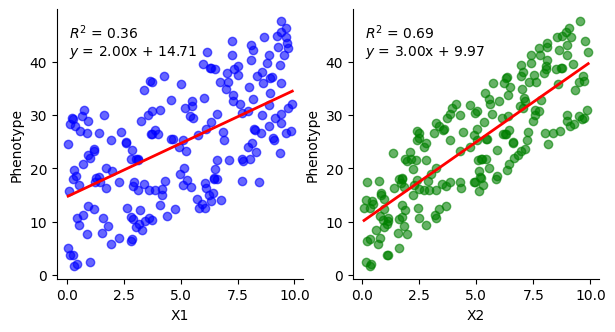

In [50]:
# Go back to the individual scatter plots and add the plane fit projected onto each 2D plot
# We can also create the plotting with a few simple lines of code
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ax[0].scatter(x1, phenotype, color='blue', alpha=0.6)
ax[0].set_xlabel('Independent Variable 1 (x1)')
ax[0].set_ylabel('Phenotype')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# Projected fit line for x1
phenotype_proj_x1 = depend_model.coef_[0] * x1 + depend_model.coef_[1] * np.mean(x2) + depend_model.intercept_
ax[0].plot(x1, phenotype_proj_x1, color='red', linewidth=2)

r2_proj_1 = depend_model.score(X, phenotype)
ax[0].text(0.05, 0.95, f'Projected $R^2$ = {r2_proj_1:.2f}', transform=ax[0].transAxes) 
ax[1].scatter(x2, phenotype, color='green', alpha=0.6)
ax[1].set_xlabel('Independent Variable 2 (x2)')
ax[1].set_ylabel('Phenotype')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# Projected fit line for x2
phenotype_proj_x2 = depend_model.coef_[1] * x2 + depend_model.coef_[0] * np.mean(x1) + depend_model.intercept_
ax[1].plot(x2, phenotype_proj_x2, color='red', linewidth=2)
r2_proj_2 = depend_model.score(X, phenotype)
ax[1].text(0.05, 0.95, f'Projected $R^2$ = {r2_proj_2:.2f}', transform=ax[1].transAxes) 
plt.show()

# But also by using the function again
# 2d Scatter plot takes a list of models for each independent variable
# So we need to make two models for each variable from the depend_model
depend_indiv_models = []
depend_model_x1 = linear_model.LinearRegression()
depend_model_x1.fit(x1.reshape(-1, 1), phenotype)
depend_model_x1.coef_ = depend_model.coef_[[0]]
depend_model_x1.intercept_ = depend_model.coef_[1] * np.mean(x2) + depend_model.intercept_
depend_indiv_models.append(depend_model_x1)

depend_model_x2 = linear_model.LinearRegression()
depend_model_x2.fit(x2.reshape(-1, 1), phenotype)
depend_model_x2.coef_ = depend_model.coef_[[1]]
depend_model_x2.intercept_ = depend_model.coef_[0] * np.mean(x1) + depend_model.intercept_
depend_indiv_models.append(depend_model_x2)
                 

fig, axes, models = plot_2d_scatter_with_fits(
    [x1, x2],
    phenotype = phenotype,
    figsize=(7, 3.5),
    models=depend_indiv_models)

In [51]:
# Now also include the uncertainty of the coefficients from the individual fits and the combined fit
import statsmodels.api as sm

# Fit individual models
X1 = sm.add_constant(x1)
model1 = sm.OLS(phenotype, X1).fit()
X2 = sm.add_constant(x2)
model2 = sm.OLS(phenotype, X2).fit()

# Fit combined model
X_combined = sm.add_constant(X)
model_combined = sm.OLS(phenotype, X_combined).fit()

# Print summary statistics
print("Individual Model 1 Summary:")
print(model1.summary())
print("\nIndividual Model 2 Summary:")
print(model2.summary())
print("\nCombined Model Summary:")
print(model_combined.summary())

Individual Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           5.62e-21
Time:                        10:07:09   Log-Likelihood:                -713.44
No. Observations:                 200   AIC:                             1431.
Df Residuals:                     198   BIC:                             1437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9969   

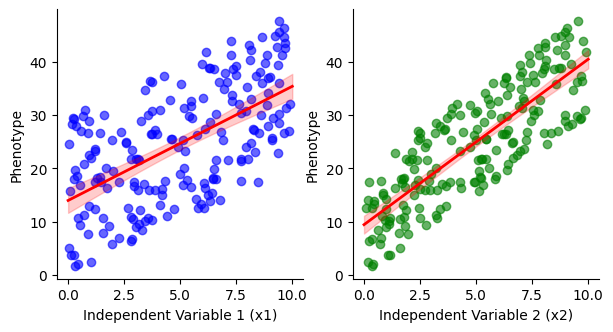

In [52]:
# Plot all three fits with confidence intervals
# Try to add the uncertainty estimates to the plotting function
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
# Individual fit for x1
ax[0].scatter(x1, phenotype, color='blue', alpha=0.6)
ax[0].set_xlabel('Independent Variable 1 (x1)')
ax[0].set_ylabel('Phenotype')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# Fit line for x1 with confidence interval
x1_fit = np.linspace(0, 10, 100)
X1_fit = sm.add_constant(x1_fit)
y1_fit = model1.predict(X1_fit)
ax[0].plot(x1_fit, y1_fit, color='red', linewidth=2)
pred1 = model1.get_prediction(X1_fit)
pred1_ci = pred1.conf_int()
ax[0].fill_between(x1_fit, pred1_ci[:, 0], pred1_ci[:, 1], color='red', alpha=0.2)
# Individual fit for x2
ax[1].scatter(x2, phenotype, color='green', alpha=0.6)
ax[1].set_xlabel('Independent Variable 2 (x2)')
ax[1].set_ylabel('Phenotype')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# Fit line for x2 with confidence interval
x2_fit = np.linspace(0, 10, 100)
X2_fit = sm.add_constant(x2_fit)
y2_fit = model2.predict(X2_fit)
ax[1].plot(x2_fit, y2_fit, color='red', linewidth=2)
pred2 = model2.get_prediction(X2_fit)
pred2_ci = pred2.conf_int()
ax[1].fill_between(x2_fit, pred2_ci[:, 0], pred2_ci[:, 1], color='red', alpha=0.2)
plt.show()


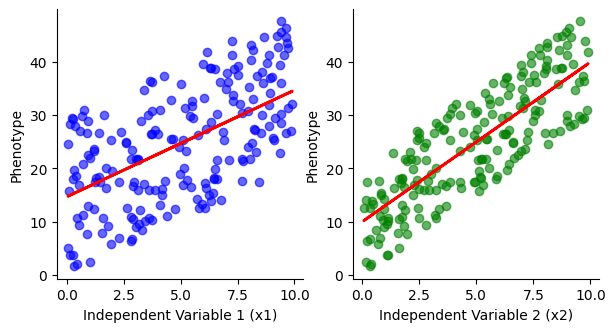

In [53]:
# Let's plot the combined fit with confidence intervals in two dimensions
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
# Combined fit projected onto x1
ax[0].scatter(x1, phenotype, color='blue', alpha=0.6)
ax[0].set_xlabel('Independent Variable 1 (x1)')
ax[0].set_ylabel('Phenotype')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# Projected fit line for x1 with confidence interval
phenotype_proj_x1 = model_combined.params[1] * x1 + model_combined.params[2] * np.mean(x2) + model_combined.params[0]
ax[0].plot(x1, phenotype_proj_x1, color='red', linewidth=2)     
# Note: statsmodels does not provide a straightforward way to get confidence intervals for projected fits
# Combined fit projected onto x2
ax[1].scatter(x2, phenotype, color='green', alpha=0.6)
ax[1].set_xlabel('Independent Variable 2 (x2)')
ax[1].set_ylabel('Phenotype')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# Projected fit line for x2 with confidence interval
phenotype_proj_x2 = model_combined.params[2] * x2 + model_combined.params[1] * np.mean(x1) + model_combined.params[0]
ax[1].plot(x2, phenotype_proj_x2, color='red', linewidth=2)     
plt.show()

## Correlated independent variables

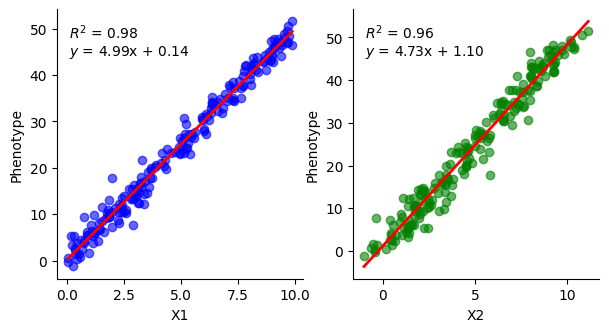

Correlated independent variables weights: 3 2
Predicted weights differ due to correlation effects: 4.992635650575323 4.729129772747074


In [61]:
# Now lets generate data where the two independent variables are correlated
# If wanted, add this function to prep_package
def generate_correlated_phenotype(num_samples=100, weights = [3, 2], noise_level=0.1, random_seed=42):
    np.random.seed(random_seed)
    # Generate one independent variable
    x1 = np.random.uniform(0, 10, num_samples)
    # Create a second variable that is correlated with the first
    x2 = x1 + np.random.normal(0, 1, num_samples)  # x2 is x1 plus some noise
    
    # Define the phenotype as a function of the two variables
    phenotype = weights[0] * x1 + weights[1] * x2
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, num_samples)
    phenotype += noise
    
    return x1, x2, phenotype

if __name__ == "__main__":
    actual_weights = [3, 2]
    x1_corr, x2_corr, phenotype_corr = generate_correlated_phenotype(num_samples=200, weights=actual_weights, noise_level=0.5, random_seed=42)
    X_corr = np.column_stack((x1_corr, x2_corr))
    
    # Plot scatter plots to visualize the relationships
    fig, axes, independ_models = plot_2d_scatter_with_fits(
    [x1_corr, x2_corr],
    phenotype = phenotype_corr,
    figsize=(7, 3.5),
    models=True,
    save_path=None
    )
    plt.show()

    print("Correlated independent variables weights:", actual_weights[0], actual_weights[1])
    print("Predicted weights differ due to correlation effects:", independ_models[0].coef_[0], independ_models[1].coef_[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.612e+04
Date:                Sat, 01 Nov 2025   Prob (F-statistic):          1.58e-290
Time:                        10:20:21   Log-Likelihood:                -145.49
No. Observations:                 200   AIC:                             297.0
Df Residuals:                     197   BIC:                             306.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0648      0.069     -0.941      0.3

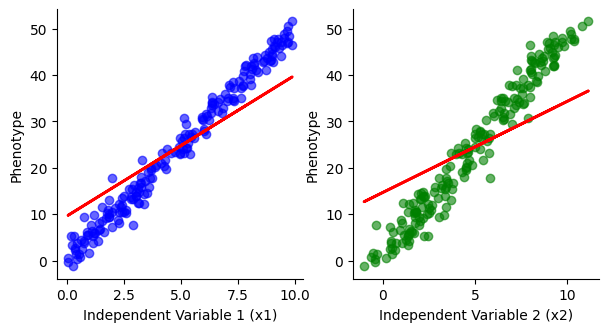

Individual Model 1 Summary (Correlated):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.105e+04
Date:                Sat, 01 Nov 2025   Prob (F-statistic):          1.17e-175
Time:                        10:20:22   Log-Likelihood:                -418.97
No. Observations:                 200   AIC:                             841.9
Df Residuals:                     198   BIC:                             848.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

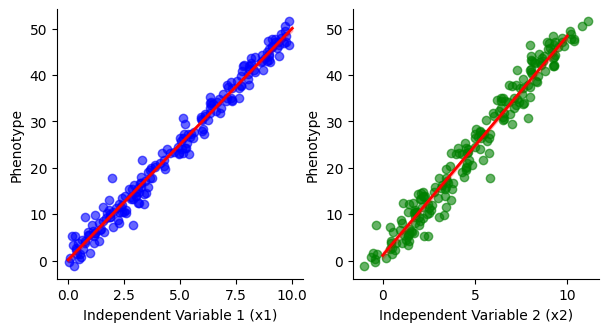

In [63]:
# The combined model recovers the weights better
# In the presence of correlation, individual models may give misleading estimates
# However, plotted onto 2D it looks like it did not work well

# Fit combined model with statsmodels to get summary statistics and uncertainty
model_corr = sm.OLS(phenotype_corr, sm.add_constant(X_corr)).fit()
print(model_corr.summary()) 
# Plot combined fit with confidence intervals
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
# Combined fit projected onto x1
ax[0].scatter(x1_corr, phenotype_corr, color='blue', alpha=0.6)
ax[0].set_xlabel('Independent Variable 1 (x1)')
ax[0].set_ylabel('Phenotype')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# Projected fit line for x1
phenotype_proj_x1_corr = model_corr.params[1] * x1_corr + model_corr.params[2] * np.mean(x2_corr) + model_corr.params[0]
ax[0].plot(x1_corr, phenotype_proj_x1_corr, color='red', linewidth=2)     
# Combined fit projected onto x2
ax[1].scatter(x2_corr, phenotype_corr, color='green', alpha=0.6)
ax[1].set_xlabel('Independent Variable 2 (x2)')
ax[1].set_ylabel('Phenotype')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# Projected fit line for x2
phenotype_proj_x2_corr = model_corr.params[2] * x2_corr + model_corr.params[1] * np.mean(x1_corr) + model_corr.params[0]
ax[1].plot(x2_corr, phenotype_proj_x2_corr, color='red', linewidth=2)     
plt.show()


# Fit individual models to see the effect of correlation
X1_corr = sm.add_constant(x1_corr)
model1_corr = sm.OLS(phenotype_corr, X1_corr).fit()
X2_corr = sm.add_constant(x2_corr)
model2_corr = sm.OLS(phenotype_corr, X2_corr).fit()
print("Individual Model 1 Summary (Correlated):")
print(model1_corr.summary())
print("\nIndividual Model 2 Summary (Correlated):")
print(model2_corr.summary())
# Plot individual fits with confidence intervals
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
# Individual fit for x1
ax[0].scatter(x1_corr, phenotype_corr, color='blue', alpha=0.6)
ax[0].set_xlabel('Independent Variable 1 (x1)')
ax[0].set_ylabel('Phenotype')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# Fit line for x1 with confidence interval
x1_fit_corr = np.linspace(0, 10, 100)
X1_fit_corr = sm.add_constant(x1_fit_corr)
y1_fit_corr = model1_corr.predict(X1_fit_corr)
ax[0].plot(x1_fit_corr, y1_fit_corr, color='red', linewidth=2)
pred1_corr = model1_corr.get_prediction(X1_fit_corr)
pred1_ci_corr = pred1_corr.conf_int()
ax[0].fill_between(x1_fit_corr, pred1_ci_corr[:, 0], pred1_ci_corr[:, 1], color='red', alpha=0.2)
# Individual fit for x2
ax[1].scatter(x2_corr, phenotype_corr, color='green', alpha=0.6)
ax[1].set_xlabel('Independent Variable 2 (x2)')
ax[1].set_ylabel('Phenotype')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# Fit line for x2 with confidence interval
x2_fit_corr = np.linspace(0, 10, 100)
X2_fit_corr = sm.add_constant(x2_fit_corr)
y2_fit_corr = model2_corr.predict(X2_fit_corr)
ax[1].plot(x2_fit_corr, y2_fit_corr, color='red', linewidth=2)
pred2_corr = model2_corr.get_prediction(X2_fit_corr)
pred2_ci_corr = pred2_corr.conf_int()
ax[1].fill_between(x2_fit_corr, pred2_ci_corr[:, 0], pred2_ci_corr[:, 1], color='red', alpha=0.2)
plt.show()

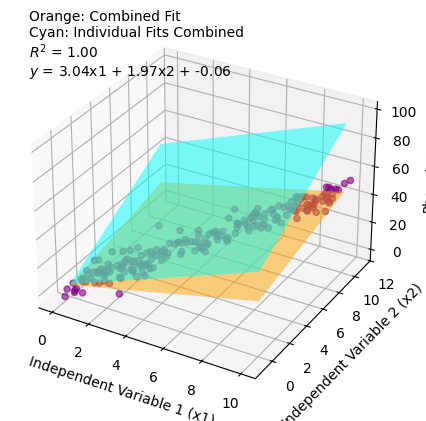

In [64]:
# Now let's plot these two approaches in 3D to visualize the plane fit
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_corr, x2_corr, phenotype_corr, color='purple', alpha=0.6)
ax.set_xlabel('Independent Variable 1 (x1)')
ax.set_ylabel('Independent Variable 2 (x2)')
ax.set_zlabel('Phenotype')
# Fit plane using both variables
model = linear_model.LinearRegression()
X = np.column_stack((x1_corr, x2_corr))
model.fit(X, phenotype_corr)
# Fit plane variables individually to show the effect of correlation
model1 = linear_model.LinearRegression()
model1.fit(x1_corr.reshape(-1, 1), phenotype_corr)
model2 = linear_model.LinearRegression()
model2.fit(x2_corr.reshape(-1, 1), phenotype_corr)
# Bring the two infividual fits together to form a plane
def predict_phenotype(x1, x2):
    return (model1.coef_[0] * x1 + model2.coef_[0] * x2 +
            (model1.intercept_ + model2.intercept_) / 2)

# Create grid to plot the plane from the fit with both variables
x1_grid, x2_grid = np.meshgrid(np.linspace(0, 10, 10), np.linspace(0, 10, 10))
phenotype_grid = model.predict(np.column_stack((x1_grid.ravel(), x2_grid.ravel()))).reshape(x1_grid.shape)
ax.plot_surface(x1_grid, x2_grid, phenotype_grid, color='orange', alpha=0.5)
# Create grid to plot the plane from the individual fits
phenotype_grid_individual = predict_phenotype(x1_grid, x2_grid).reshape(x1_grid.shape)
ax.plot_surface(x1_grid, x2_grid, phenotype_grid_individual, color='cyan', alpha=0.5)
# Add legend
ax.text2D(0.05, 0.95, 'Orange: Combined Fit\nCyan: Individual Fits Combined', transform=ax.transAxes)
# Show R^2 and equation for combined fit
r2 = model.score(X, phenotype_corr)
ax.text2D(0.05, 0.85, f'$R^2$ = {r2:.2f}\n$y$ = {model.coef_[0]:.2f}x1 + {model.coef_[1]:.2f}x2 + {model.intercept_:.2f}', transform=ax.transAxes)
plt.show()
